0. [📚 Table of Contents](#📚-table-of-contents)
1. [0- Requirements](#0--requirements)
2. [1- Explaining the problem and the dataset](#1--explaining-the-problem-and-the-dataset)
3. [2- Loading and Preprocessing the Dataset](#2--loading-and-preprocessing-the-dataset)
4. [3- Regular Machine Learning Models](#3--regular-machine-learning-models)
5. [4-CNN](#4-cnn)
6. [5-VGG16](#5-vgg16)
7. [6- ResNet50](#6--resnet50)
8. [7- Evaluation](#7--evaluation)
9. [8-References](#8-references)
10. [9-GPT Use](#9-gpt-use)

# 0- Requirements

In [47]:
from tensorflow import keras
from keras.utils import image_dataset_from_directory, img_to_array
from PIL import Image
from skimage.io import imread, imshow
from matplotlib import pyplot as plt
from collections import Counter
import logging
import numpy as np
import os
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# 1- Explaining the problem and the dataset

> ​The PlantVillage dataset is a valuable collection of over 54,000 images of plant leaves, encompassing both healthy specimens and those affected by various diseases. 

> These images represent 14 different crop species and cover 38 distinct categories, including specific diseases and healthy instances. 

> We use a kaggle dataset based on this dataset with a train and validation set. We have a greater number of images thanks to newly introduced augmented images in the dataset.

> Our train dataset contains over 70K samples, while our test set contains over 17K samples.

>  This dataset encompasses 14 different crop species and covers 26 distinct diseases, providing a rich resource for training machine learning models aimed at disease identification.

Number of images of Tomato___Late_blight: 1851 ||
Number of images of Tomato___healthy: 1926 ||
Number of images of Grape___healthy: 1692 ||
Number of images of Orange___Haunglongbing_(Citrus_greening): 2010 ||
Number of images of Soybean___healthy: 2022 ||
Number of images of Squash___Powdery_mildew: 1736 ||
Number of images of Potato___healthy: 1824 ||
Number of images of Corn_(maize)___Northern_Leaf_Blight: 1908 ||
Number of images of Tomato___Early_blight: 1920 ||
Number of images of Tomato___Septoria_leaf_spot: 1745 ||
Number of images of Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 1642 ||
Number of images of Strawberry___Leaf_scorch: 1774 ||
Number of images of Peach___healthy: 1728 ||
Number of images of Apple___Apple_scab: 2016 ||
Number of images of Tomato___Tomato_Yellow_Leaf_Curl_Virus: 1961 ||
Number of images of Tomato___Bacterial_spot: 1702 ||
Number of images of Apple___Black_rot: 1987 ||
Number of images of Blueberry___healthy: 1816 ||
Number of images of Cherry

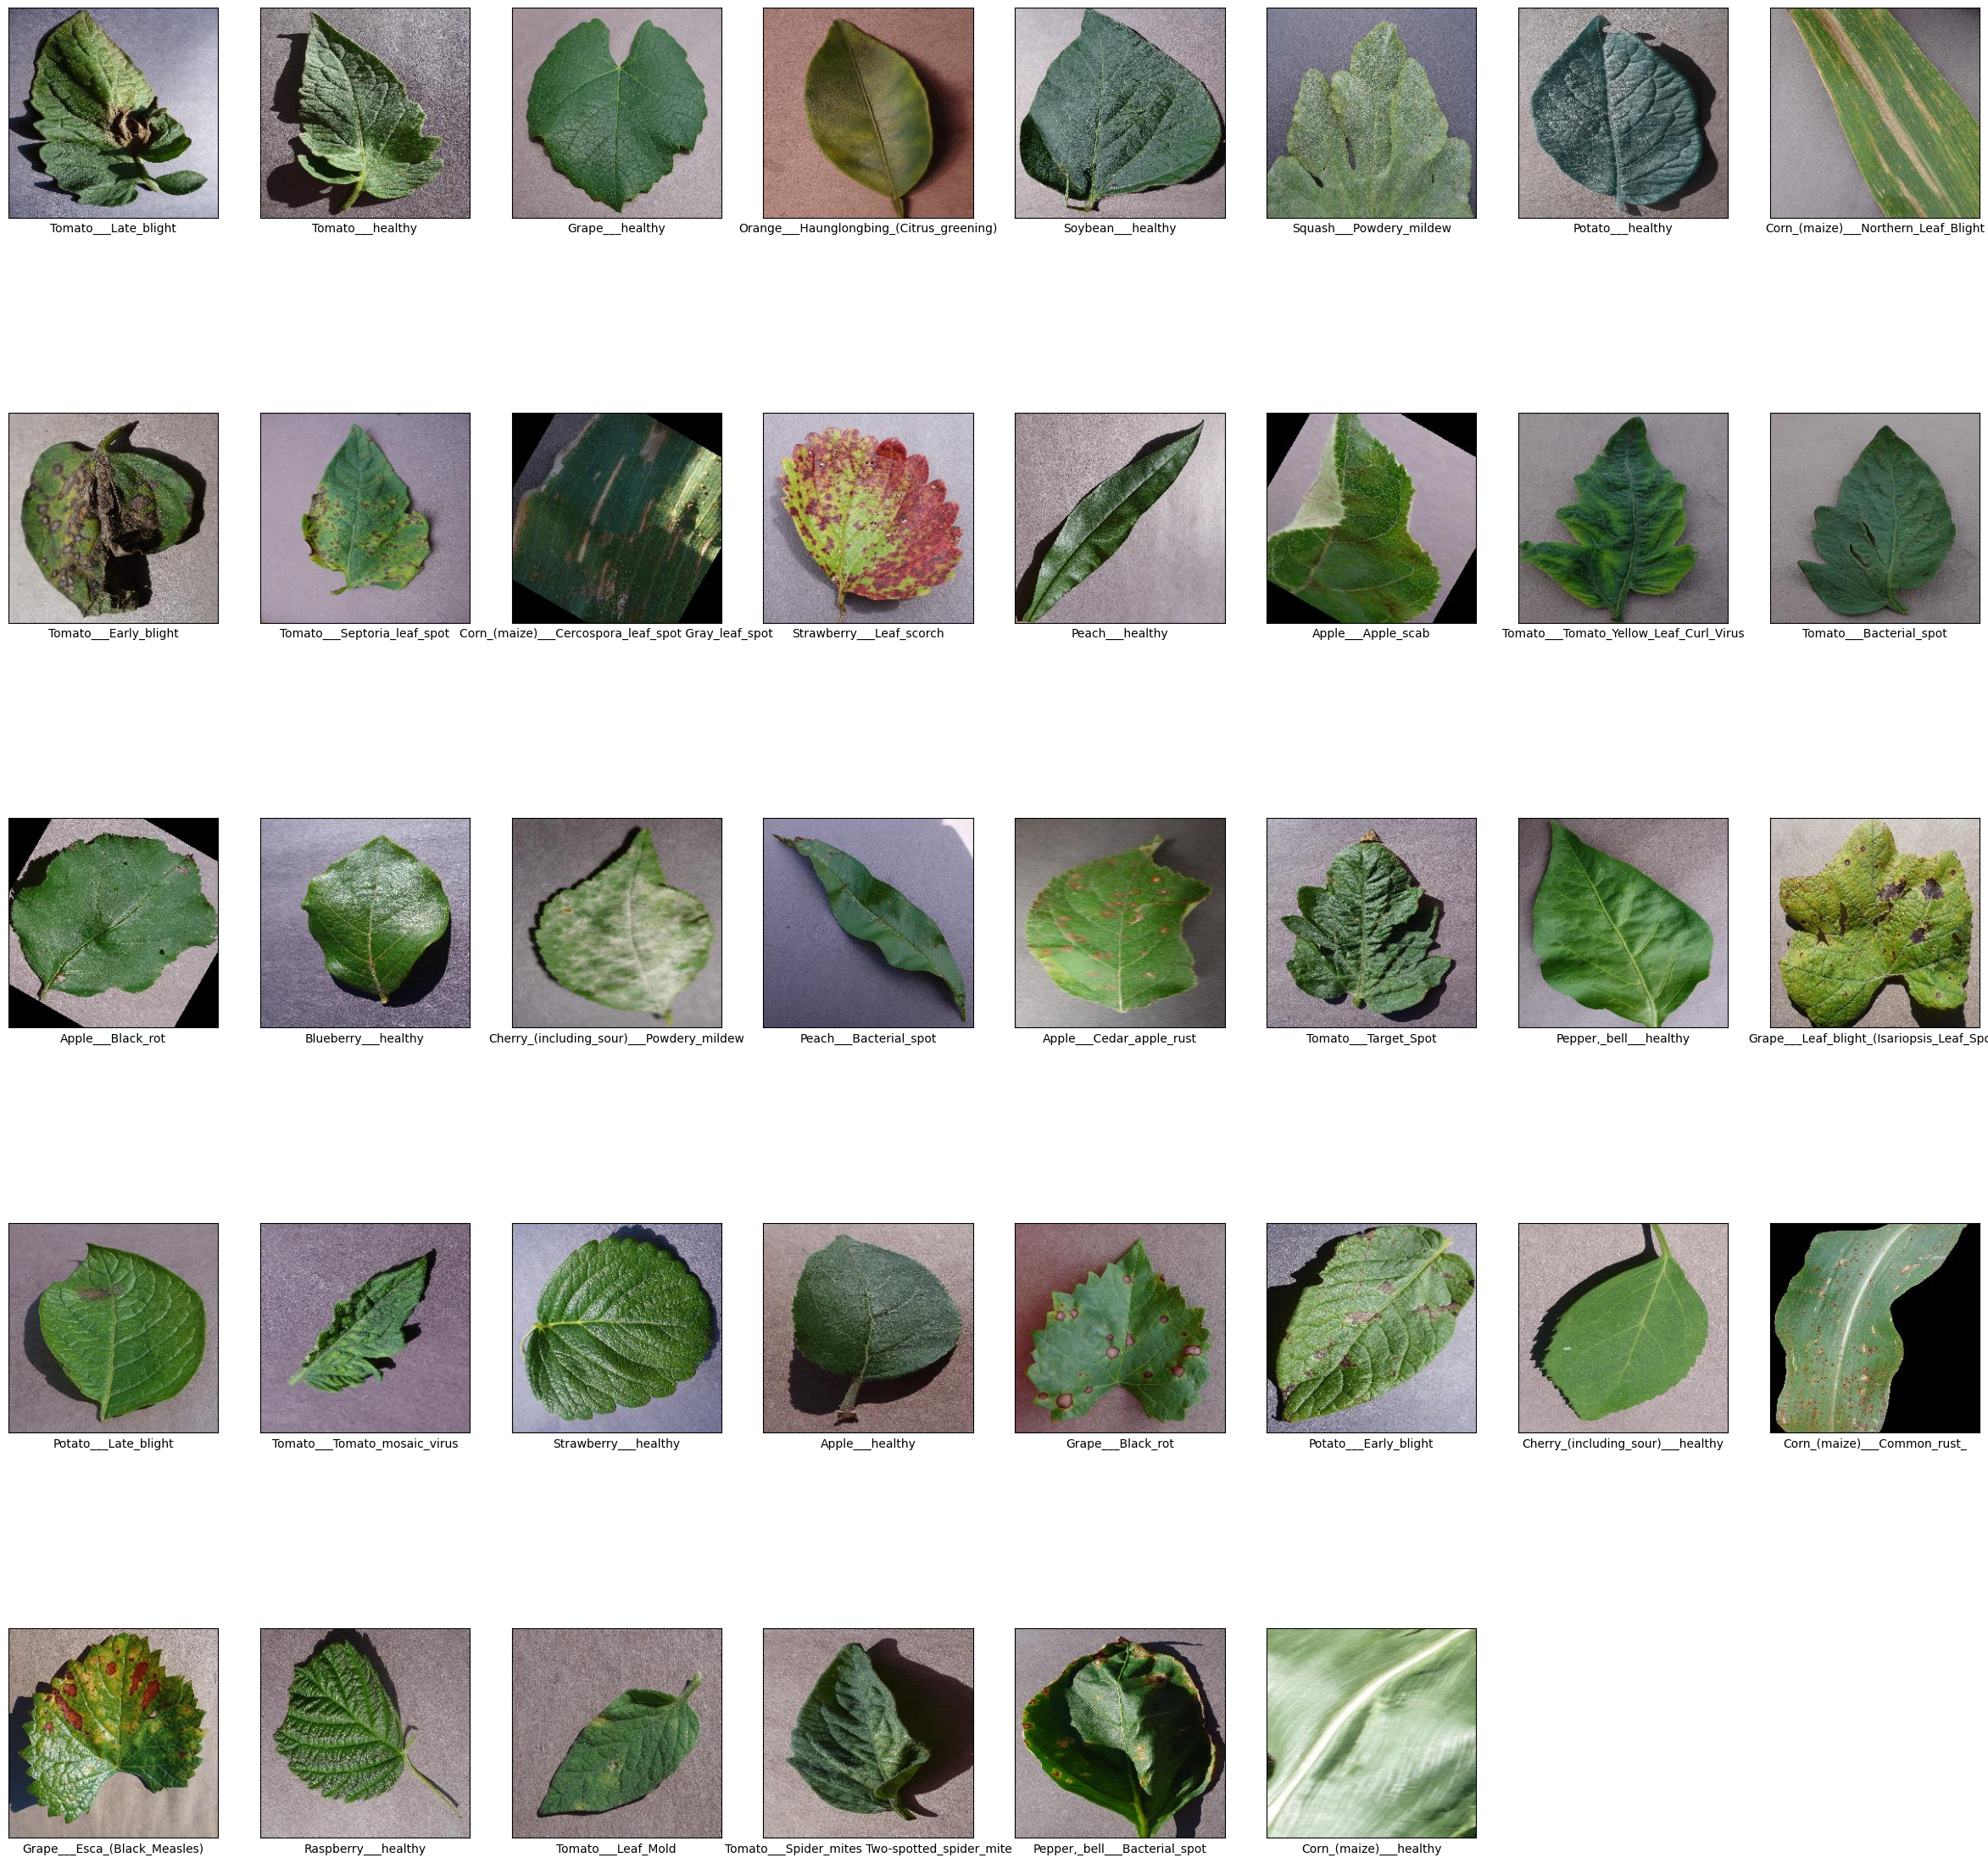

In [63]:
path="/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"
plt.figure(figsize=(30,30))
count=0
plant_names=[]
total_images=0
for i in os.listdir(path):
  count+=1
  plant_names.append(i)
  plt.subplot(5,8,count)

  images_path=os.listdir(path+"/"+i)
  print("Number of images of "+i+":",len(images_path),"||",end="\n")
  total_images+=len(images_path)

  image_show=plt.imread(path+"/"+i+"/"+images_path[0])
  
  plt.imshow(image_show)
  plt.xlabel(i,fontsize=10)
  
  plt.xticks([])
  plt.yticks([])


print("Total number of images we have",total_images)

# 2- Loading and Preprocessing the Dataset

In [76]:
train_dataset_generator=image_dataset_from_directory(directory="/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train",
    batch_size=32,
    image_size=(256,256)
    )

validation_dataset_generator=image_dataset_from_directory(directory="/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid",
    batch_size=32,
    image_size=(256,256))

# We've used lazy loading technique to prevent overloading RAM by using generators provided by keras.
# The use of this method was necessary since the dataset is too large to fit into RAM. (Nearly 3GB)


Found 70295 files belonging to 38 classes.
Found 17572 files belonging to 38 classes.


In [77]:
len(train_dataset_generator.class_names)
# We have a total of 38 classes.

38

In [78]:
train_dataset_generator.class_names

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_

In [79]:
import os
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

root_dir = "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"

# Iterate through folders and log the number of images
for class_folder in os.listdir(root_dir):
    class_path = os.path.join(root_dir, class_folder)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        logging.info(f"{class_folder}: {num_images} images found.")


In [80]:
class_names=train_dataset_generator.class_names
label_counter = Counter()
for images,labels in train_dataset_generator:
    labels= labels.numpy()
    label_counter.update(labels)

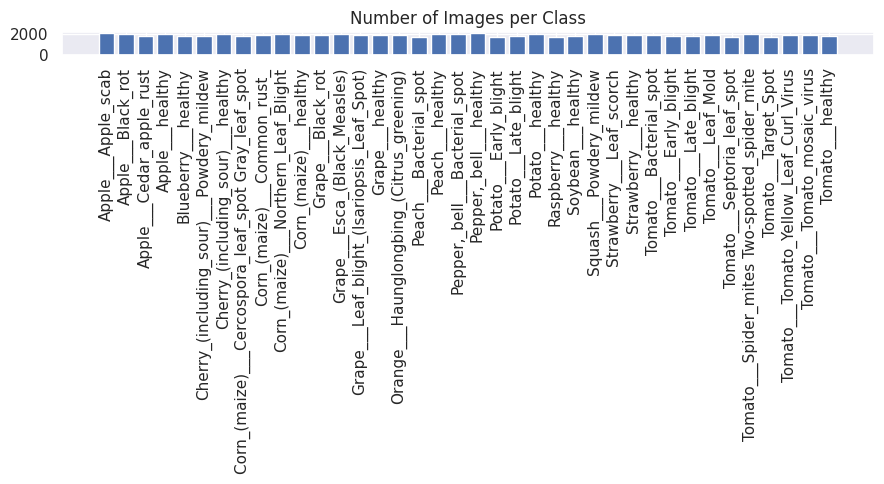

In [81]:
plt.figure(figsize=(9,5))
plt.bar(class_names, label_counter.values())
plt.title('Number of Images per Class')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# The distribution of instances across the categories is almost so no need to upsample or downsample.
# We need to check to be sure so this is my we have this plot.

In [82]:
for image, label in train_dataset_generator.take(1):
    print(image[0].shape) 
# Checking width and height of images for input_shape parameter in the models.

(256, 256, 3)


In [83]:
for image, label in train_dataset_generator.take(1):
    print(np.mean(image[0]/256,axis=2)) #label

## For some models we'll rescale our pixel values to speed up computation and lessen the burden of neural networks.
## These models will be Traditional ML techniques,CNN, and VGG16.
## Not doing this for ResNet50 since there is already a function existing for preprocessing inputs to be fed to ResNet50

[[0.4049479  0.40104166 0.4283854  ... 0.53255206 0.55859375 0.57421875]
 [0.4361979  0.4596354  0.4518229  ... 0.5442708  0.5572917  0.56901044]
 [0.3736979  0.42447916 0.4205729  ... 0.54036456 0.54036456 0.5598958 ]
 ...
 [0.4375     0.4140625  0.4375     ... 0.4674479  0.4908854  0.51432294]
 [0.44140625 0.4296875  0.44140625 ... 0.4830729  0.47916666 0.47916666]
 [0.43359375 0.421875   0.42578125 ... 0.4986979  0.4752604  0.4440104 ]]


In [84]:
# In this section we'll showcase some models we deem essential based on what other people did in the past to not waste time going through
# all kinds of models. Most promising ones were already discovered. Though on top of those most promising ones I'll also train traditional models
# to show the distinct difference between Neural Networks(specifically CNN) and traditional methods.

# 3- Regular Machine Learning Models

In [107]:
import os
import numpy as np
from PIL import Image
import logging

# Setup basic logging config
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# A class is created to implement lazy learning to make it a lot more efficient for tradition ML models which only accepts flat arrays.
# It's unprobable  to feed these images in batch since it would go against the architecture of those models.
# Therefore we are forced to load all the data in one go using this class.
# Another change made specficially for these methods was to reduce image size to (32,32) with grayscale. (To speedup things)
class LazyImageDataset:
    def __init__(self, dir_path, labels, img_size=(32,32)):
        self.filepaths = []
        self.targets = []
        self.img_size = img_size

        logging.info("Initializing LazyImageDataset...")
        for label in labels:
            comp_path = os.path.join(dir_path, label)
            if not os.path.exists(comp_path):
                logging.warning(f"Directory for label '{label}' not found: {comp_path}")
                continue
            file_list = os.listdir(comp_path)
            logging.info(f"Label '{label}' — Found {len(file_list)} images.")
            for fname in file_list:
                full_path = os.path.join(comp_path, fname)
                self.filepaths.append(full_path)
                self.targets.append(label)

        logging.info(f"Total images loaded: {len(self.filepaths)}")

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        img_path = self.filepaths[idx]
        try:
            img = Image.open(img_path).convert("L")
            img.thumbnail(self.img_size)
            img = np.asarray(img).astype(np.float32) / 256.0
            img = img.flatten()
            label = self.targets[idx]
            logging.debug(f"Loaded image: {img_path} | Label: {label}")
            return img, label
        except Exception as e:
            logging.error(f"Error loading image: {img_path} — {e}")
            raise

    def get_all(self, show_progress=True):
        X = []
        y = []
        total = len(self)
        for i in range(total):
            if show_progress and i % 500 == 0:
                logging.info(f"Loading image {i}/{total}...")
            xi, yi = self[i]
            X.append(xi)
            y.append(yi)
        logging.info("Finished loading all images.")
        return np.array(X), np.array(y)


dataset = LazyImageDataset("/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train",class_names)

# Load on demand, convert to arrays
X, y = dataset.get_all()

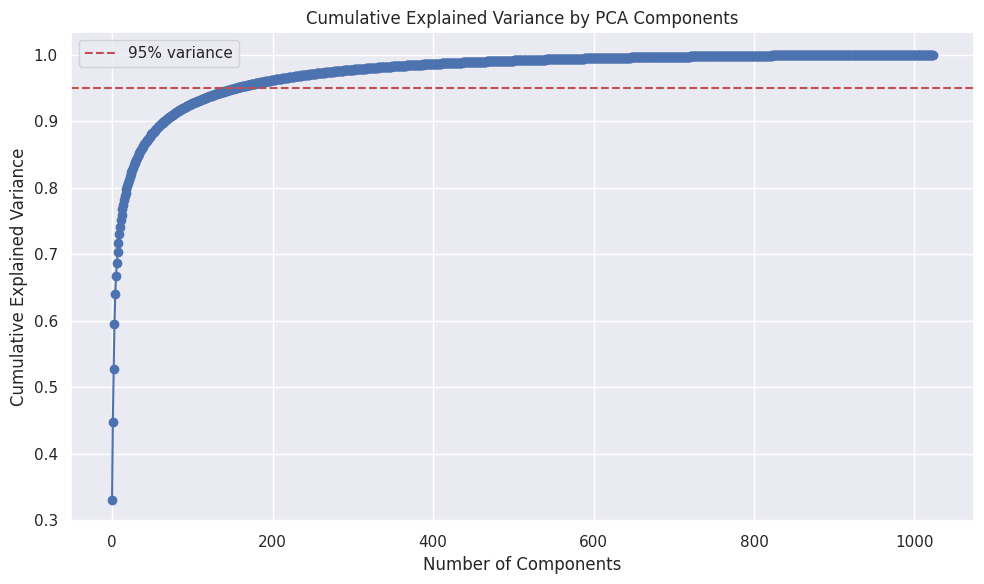

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


# To further speed up things for our Traditional models, a feature selection method called PCA was implemented. It's simple but yet effective.
# At the end of the day, images will be represented as a flat array and some of the numbers in these arrays are not contributing to information.
# Using PCA for each number of total features starting from the most informative one to least, summing them up as we go by.
# We'll use the number where the information percentage or (Explained Variance Ratio) doesn't change drastically anymore.

pca = PCA().fit(X)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o')
plt.title("Cumulative Explained Variance by PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
plt.legend()
plt.tight_layout()
plt.show()


In [110]:
# Although there is a drastic change until 50 features, after it the increase rate diminishes.

pca = PCA(n_components=50)
pca.fit(X)
np.cumsum(pca.explained_variance_ratio_)

array([0.33074103, 0.44736153, 0.52700083, 0.59498927, 0.64015191,
       0.66804045, 0.68616933, 0.70271491, 0.71646209, 0.72989844,
       0.74153763, 0.75106525, 0.7594527 , 0.7673574 , 0.77449253,
       0.78121341, 0.78719505, 0.79257697, 0.79757209, 0.80235214,
       0.80701424, 0.81162835, 0.81585528, 0.81990623, 0.82380438,
       0.82705921, 0.83027896, 0.83339328, 0.83642   , 0.83925299,
       0.84205665, 0.84484902, 0.84747523, 0.849994  , 0.85238578,
       0.85468394, 0.85687105, 0.85902238, 0.86111958, 0.86314979,
       0.86507164, 0.86692154, 0.86871128, 0.87043061, 0.87210607,
       0.87374535, 0.87534814, 0.87692388, 0.87848064, 0.8800063 ])

In [111]:
pca = PCA(n_components=50)
X_reduced = pca.fit_transform(X)


In [45]:
# This is used for keeping myself informed about the process
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Creating a model and parameter grid. Then these combinations will be fed to the pipeline.
models_and_params = {
    "RandomForest": {
        "model": RandomForestClassifier(),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [None, 10],
            "max_features": ["sqrt", "log2"]
        }
    },
    "SVM": {
        "model": SVC(),
        "params": {
            "C": [0.1, 1, 10, 100],
            "kernel": ["linear", "rbf"]
        }
    },
    "LogisticRegression": {
        "model": LogisticRegression(max_iter=1000),
        "params": {
            "C": [0.1, 1],
            "penalty": ["l2"],
            "solver": ["liblinear", "saga"]
        }
    }
}

results = []

# Start training process
logging.info(" Starting grid search on reduced features...")

for name, config in models_and_params.items():
    logging.info(f" Running GridSearchCV for: {name}")
    
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", config["model"])
    ])

    param_grid = {f"clf__{k}": v for k, v in config["params"].items()}
    logging.info(f"🔧 Hyperparameter grid for {name}: {param_grid}")

    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=3,
        scoring="accuracy",
        n_jobs=-1,
        return_train_score=False
    )

    logging.info(f" Fitting model: {name}")
    grid.fit(X_reduced, y)
    logging.info(f" Done training {name}. Collecting results...")

    for i in range(len(grid.cv_results_["mean_test_score"])):
        param_set = grid.cv_results_["params"][i]
        score = grid.cv_results_["mean_test_score"][i]
        logging.info(f" {name} | Params: {param_set} | Accuracy: {score:.4f}")
        results.append({
            "Model": name,
            "Params": param_set,
            "Accuracy": score
        })

# Sort and show top 10
logging.info(" Sorting top 10 results by accuracy...")
df_results = pd.DataFrame(results)
top_10 = df_results.sort_values(by="Accuracy", ascending=False).head(10)

logging.info("\n Top 10 Models:\n" + top_10.to_string(index=False))


2025-03-28 23:14:58,326 - INFO - 🔥 Starting grid search on reduced features...
2025-03-28 23:14:58,327 - INFO - 🚀 Running GridSearchCV for: RandomForest
2025-03-28 23:14:58,328 - INFO - 🔧 Hyperparameter grid for RandomForest: {'clf__n_estimators': [100, 200], 'clf__max_depth': [None, 10], 'clf__max_features': ['sqrt', 'log2']}
2025-03-28 23:14:58,329 - INFO - 🧠 Fitting model: RandomForest
2025-03-28 23:53:04,099 - INFO - ✅ Done training RandomForest. Collecting results...
2025-03-28 23:53:04,101 - INFO - 📊 RandomForest | Params: {'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__n_estimators': 100} | Accuracy: 0.5308
2025-03-28 23:53:04,101 - INFO - 📊 RandomForest | Params: {'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__n_estimators': 200} | Accuracy: 0.5461
2025-03-28 23:53:04,102 - INFO - 📊 RandomForest | Params: {'clf__max_depth': None, 'clf__max_features': 'log2', 'clf__n_estimators': 100} | Accuracy: 0.5259
2025-03-28 23:53:04,102 - INFO - 📊 RandomForest | Pa

# 4-CNN

>Convolutional Neural Networks (CNNs) are a type of deep learning model that are really good at recognizing patterns in images—like spots, colors, or shapes on plant leaves. In plant disease detection, CNNs can automatically learn these patterns from thousands of leaf images to figure out which disease a plant might have.

>Unlike traditional methods, which often rely on hand-crafted features or expert knowledge, CNNs don’t need us to manually tell them what to look for. They learn directly from the data, which makes them more accurate and faster—especially when working with large numbers of images.

In [29]:
model = keras.Sequential()
model.add(keras.layers.Input(shape=(256,256,3)))
model.add(keras.layers.Rescaling(1./255))
model.add(keras.layers.Conv2D(32,(3,3),activation="relu",padding="same"))
model.add(keras.layers.Conv2D(32,(3,3),activation="relu",padding="same"))
model.add(keras.layers.MaxPooling2D(3,3))

model.add(keras.layers.Conv2D(64,(3,3),activation="relu",padding="same"))
model.add(keras.layers.Conv2D(64,(3,3),activation="relu",padding="same"))
model.add(keras.layers.MaxPooling2D(3,3))

model.add(keras.layers.Conv2D(128,(3,3),activation="relu",padding="same"))
model.add(keras.layers.Conv2D(128,(3,3),activation="relu",padding="same"))
model.add(keras.layers.MaxPooling2D(3,3))

model.add(keras.layers.Conv2D(256,(3,3),activation="relu",padding="same"))
model.add(keras.layers.Conv2D(256,(3,3),activation="relu",padding="same"))

model.add(keras.layers.Conv2D(512,(5,5),activation="relu",padding="same"))
model.add(keras.layers.Conv2D(512,(5,5),activation="relu",padding="same"))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(1568,activation="relu"))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(38,activation="softmax"))

opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt,loss="sparse_categorical_crossentropy",metrics=['accuracy'])
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 256, 256, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 85, 85, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 85, 85, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 85, 85, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 28, 28, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (None, 9, 9, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 9, 9, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_48 (Conv2D)                   │ (None, 9, 9, 512)           │       3,277,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_49 (Conv2D)                   │ (None, 9, 9, 512)           │       6,554,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 41472)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1568)                │      65,029,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1568)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 38)                  │          59,622 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 76,092,966 (290.27 MB)

 Trainable params: 76,092,966 (290.27 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# This one needs early-stop to avoid overfitting
early_stop=keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights = True)
#https://www.tensorflow.org/guide/data_performance#optimize_performance
train_dataset_generator = train_dataset_generator.prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset_generator = validation_dataset_generator.prefetch(buffer_size=tf.data.AUTOTUNE)

history = model.fit(train_dataset_generator,
                    callbacks=early_stop,
                    validation_data=validation_dataset_generator,
                    epochs = 10)

Epoch 1/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 189s 81ms/step - accuracy: 0.3264 - loss: 2.3668 - val_accuracy: 0.8410 - val_loss: 0.5054
Epoch 2/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 160s 73ms/step - accuracy: 0.8389 - loss: 0.5074 - val_accuracy: 0.9115 - val_loss: 0.2713
Epoch 3/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 160s 73ms/step - accuracy: 0.9059 - loss: 0.2878 - val_accuracy: 0.9372 - val_loss: 0.1950
Epoch 4/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 160s 73ms/step - accuracy: 0.9329 - loss: 0.1997 - val_accuracy: 0.9444 - val_loss: 0.1666
Epoch 5/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 160s 73ms/step - accuracy: 0.9516 - loss: 0.1468 - val_accuracy: 0.9564 - val_loss: 0.1318
Epoch 6/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 160s 73ms/step - accuracy: 0.9636 - loss: 0.1091 - val_accuracy: 0.9585 - val_loss: 0.1256
Epoch 7/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 160s 73ms/step - accuracy: 0.9672 - loss: 0.0985 - val_accuracy: 0.9563 - val_loss: 0.1335
Epoch 8/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 160s 73ms/step - accuracy: 

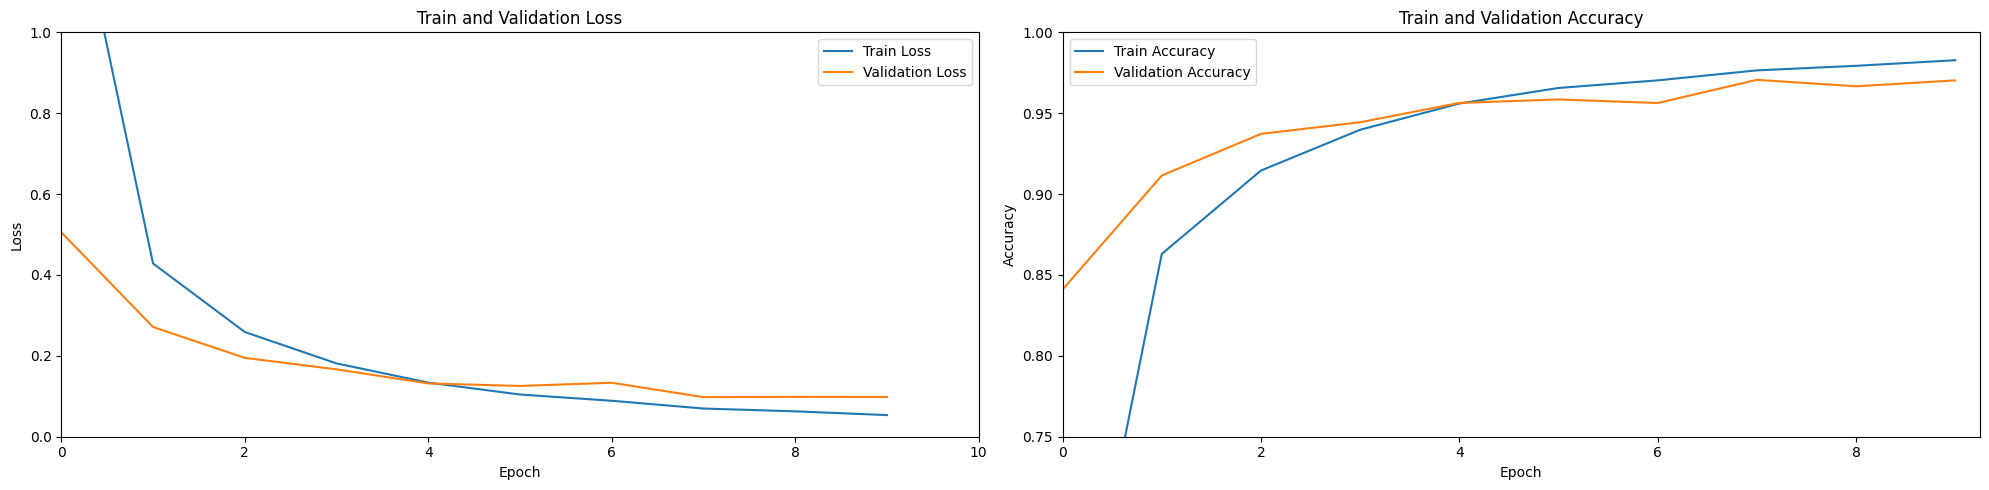

In [32]:
plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
plt.title("Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history['loss'],label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlim(0, 10)
plt.ylim(0.0,1.0)
plt.legend()

plt.subplot(1,2,2)
plt.title("Train and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlim(0, 9.25)
plt.ylim(0.75,1.0)
plt.legend()
plt.tight_layout()
plt.show()

# 5-VGG16

> In this section we'll use functional API to create models combining pre-trained models and some extra layers to improve the performance.

> These extra layers will be fully connected layers taking care of the learning part of the problem while convolution part of the problem will be

> taken care of by the pre-trained models's weights. We'll freeze these lower layer weights so as to speed things up and keep it simple.  

In [85]:
inputs = keras.Input(shape=(256, 256, 3))
x = keras.layers.Rescaling(1./255)(inputs)
vgg16_without_top_layer = keras.applications.VGG16(include_top=False,input_tensor=x,classes=38)
vgg16_without_top_layer.trainable = False
vgg16_without_top_layer.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)          │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_9 (Rescaling)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 256, 256, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 32, 32, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [86]:
flat = keras.layers.Flatten()(vgg16_without_top_layer.layers[-1].output)
dense1 = keras.layers.Dense(512, activation="relu")(flat)
dense2 = keras.layers.Dense(256, activation="relu")(dense1)
output = keras.layers.Dense(38, activation="softmax")(dense2)
vgg16_transfer_learning = keras.Model(inputs = vgg16_without_top_layer.inputs, outputs = output)
vgg16_transfer_learning.summary()

Model: "functional_99"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)          │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_9 (Rescaling)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 256, 256, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 32, 32, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_14 (Flatten)                 │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 31,633,510 (120.67 MB)

 Trainable params: 16,918,822 (64.54 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [87]:
vgg16_transfer_learning.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#note that I leave the callback as it is
# no need to rescale our values since VGG16 uses pixel values between 0 and 255
early_stop=keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights = True)
train_dataset_generator = train_dataset_generator.prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset_generator = validation_dataset_generator.prefetch(buffer_size=tf.data.AUTOTUNE)
vgg16_transfer_learning_history = model_transfer_learning.fit(train_dataset_generator,
                                                              epochs=10,verbose=1,
                                                              validation_data=validation_dataset_generator, 
                                                              callbacks=early_stop)

Epoch 1/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 156s 71ms/step - accuracy: 0.9925 - loss: 0.0716 - val_accuracy: 0.9677 - val_loss: 0.4304
Epoch 2/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 156s 71ms/step - accuracy: 0.9931 - loss: 0.0639 - val_accuracy: 0.9702 - val_loss: 0.2447
Epoch 3/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 156s 71ms/step - accuracy: 0.9933 - loss: 0.0656 - val_accuracy: 0.9783 - val_loss: 0.2339
Epoch 4/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 155s 71ms/step - accuracy: 0.9945 - loss: 0.0509 - val_accuracy: 0.9740 - val_loss: 0.2790
Epoch 5/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 155s 71ms/step - accuracy: 0.9943 - loss: 0.0522 - val_accuracy: 0.9713 - val_loss: 0.3482
Epoch 6/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 155s 71ms/step - accuracy: 0.9949 - loss: 0.0501 - val_accuracy: 0.9739 - val_loss: 0.3254


# 6- ResNet50

In [53]:
inputs = tf.keras.Input(shape=(256, 256, 3))
## Here we did preprocessing differently since ResNet50 expects a different kind of input than CNN or VGG16.
## It has a unique preprocessing function designed specifically for ResNet50 model.
## This preprocess_input function applies specific transformations (such as subtracting the mean pixel values computed on the ImageNet dataset) 
## that match the conditions under which the model was originally trained.
## I was having trouble understanding the exceptionally bad performance of ResNet50 with Rescaling layer but then found that the function below is the
## right way to do preprocessing.
x = preprocess_input(inputs)
resnet=keras.applications.ResNet50(include_top=False,weights="imagenet",classes=38,input_tensor=x)
resnet.trainable=False
resnet.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11            │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_3 (GetItem)      │ (None, 256, 256)       │              0 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_4 (GetItem)      │ (None, 256, 256)       │              0 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_5 (GetItem)      │ (None, 256, 256)       │              0 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack_1 (Stack)           │ (None, 256, 256, 3)    │              0 │ get_item_3[0][0],      │
│                           │                        │                │ get_item_4[0][0],      │
│                           │                        │                │ get_item_5[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 256, 256, 3)    │              0 │ stack_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)             

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [54]:
flat = keras.layers.Flatten()(resnet.layers[-1].output)
dense1 = keras.layers.Dense(512, activation="relu")(flat)
dense2 = keras.layers.Dense(512, activation="relu")(dense1)
output = keras.layers.Dense(38, activation="softmax")(dense2)

model_transfer_learning = keras.Model(inputs = resnet.inputs, outputs = output)
model_transfer_learning.summary()

Model: "functional_97"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11            │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_3 (GetItem)      │ (None, 256, 256)       │              0 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_4 (GetItem)      │ (None, 256, 256)       │              0 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_5 (GetItem)      │ (None, 256, 256)       │              0 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack_1 (Stack)           │ (None, 256, 256, 3)    │              0 │ get_item_3[0][0],      │
│                           │                        │                │ get_item_4[0][0],      │
│                           │                        │                │ get_item_5[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 256, 256, 3)    │              0 │ stack_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)             

 Total params: 90,979,238 (347.06 MB)

 Trainable params: 67,391,526 (257.08 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [55]:
model_transfer_learning.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stop=keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights = True)
model_transfer_learning_history = model_transfer_learning.fit(train_dataset_generator,
                                                              epochs=10,verbose=1,
                                                              validation_data=validation_dataset_generator, 
                                                              callbacks=early_stop)

Epoch 1/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 176s 76ms/step - accuracy: 0.8157 - loss: 2.6944 - val_accuracy: 0.9367 - val_loss: 0.3300
Epoch 2/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 160s 73ms/step - accuracy: 0.9547 - loss: 0.2111 - val_accuracy: 0.9557 - val_loss: 0.2041
Epoch 3/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 159s 73ms/step - accuracy: 0.9695 - loss: 0.1454 - val_accuracy: 0.9566 - val_loss: 0.2430
Epoch 4/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 159s 73ms/step - accuracy: 0.9752 - loss: 0.1263 - val_accuracy: 0.9656 - val_loss: 0.2391
Epoch 5/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 159s 72ms/step - accuracy: 0.9818 - loss: 0.1022 - val_accuracy: 0.9647 - val_loss: 0.3221
Epoch 6/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 160s 73ms/step - accuracy: 0.9831 - loss: 0.1075 - val_accuracy: 0.9697 - val_loss: 0.2839
Epoch 7/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 159s 73ms/step - accuracy: 0.9863 - loss: 0.1067 - val_accuracy: 0.9698 - val_loss: 0.2428
Epoch 8/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 159s 72ms/step - accuracy: 

# 7- Evaluation

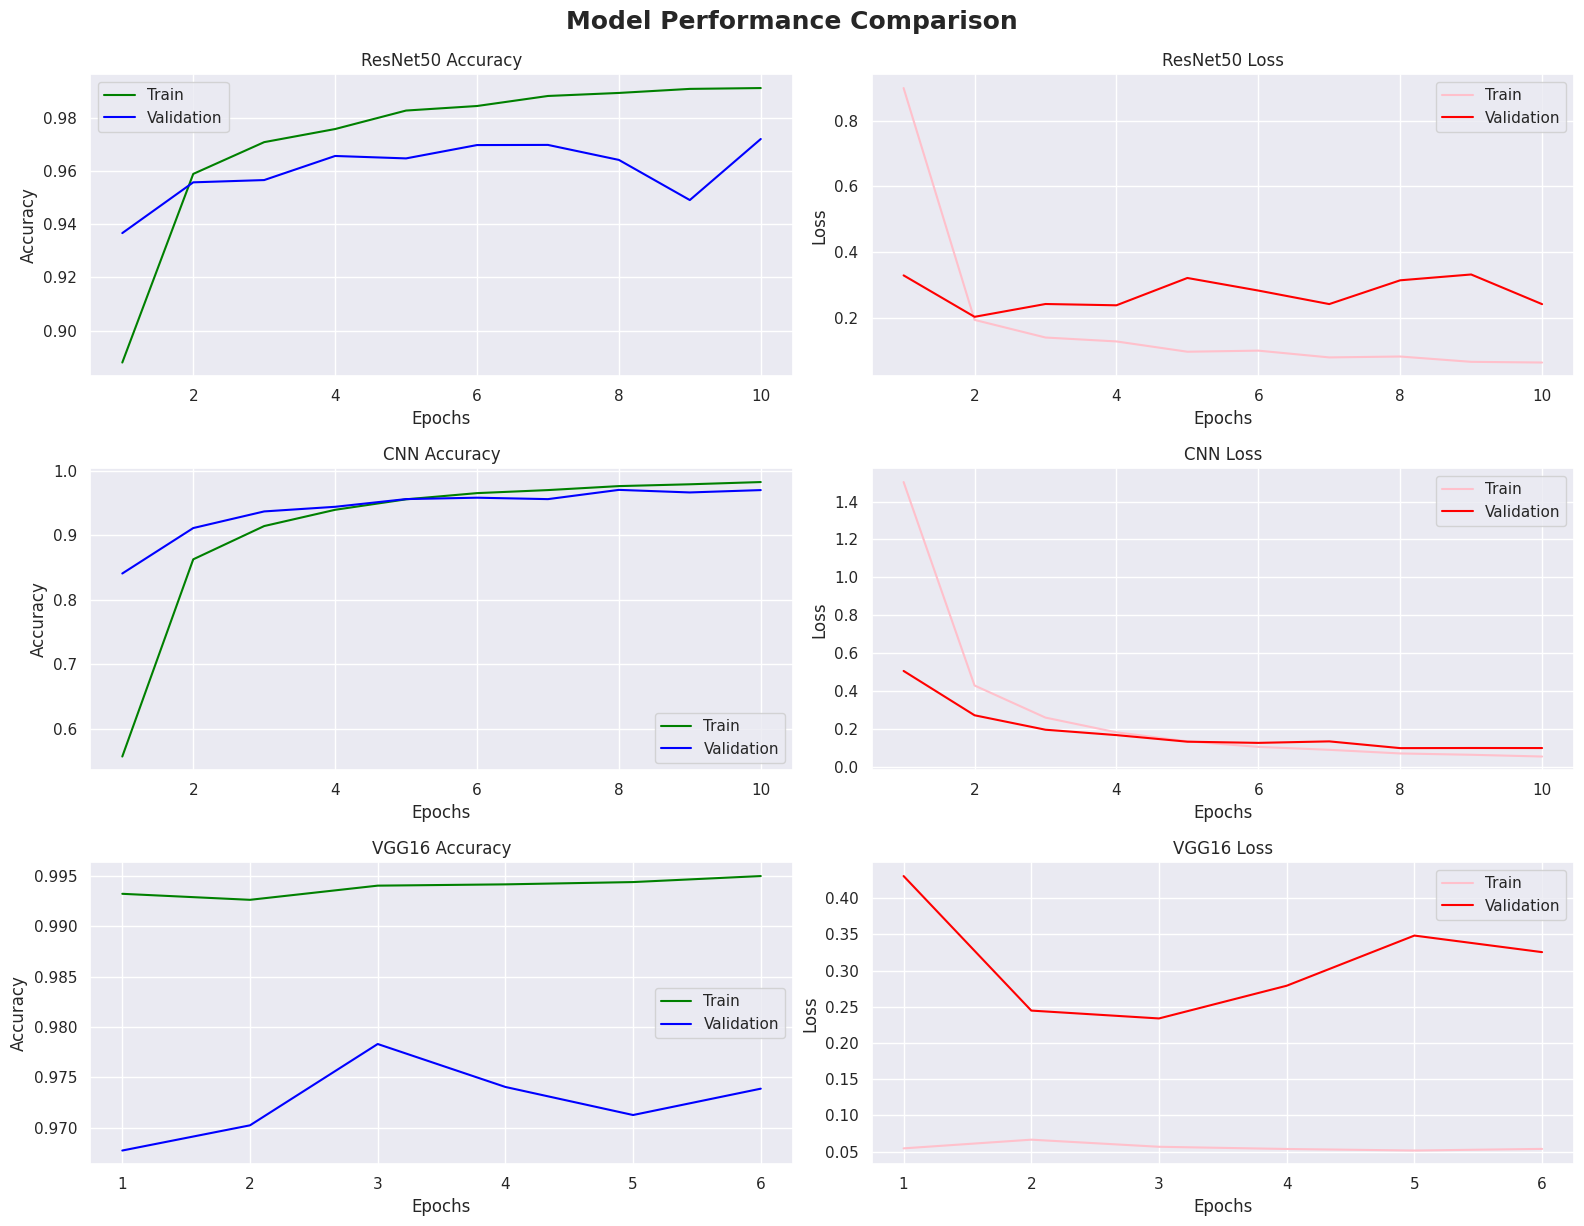

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

# 1️⃣ ResNet50
acc_res = model_transfer_learning_history.history['accuracy']
val_acc_res = model_transfer_learning_history.history['val_accuracy']
loss_res = model_transfer_learning_history.history['loss']
val_loss_res = model_transfer_learning_history.history['val_loss']
epochs_res = range(1, len(loss_res) + 1)

# 2️⃣ Custom CNN
acc_cnn = history.history['accuracy']
val_acc_cnn = history.history['val_accuracy']
loss_cnn = history.history['loss']
val_loss_cnn = history.history['val_loss']
epochs_cnn = range(1, len(loss_cnn) + 1)

# 3️⃣ VGG16
acc_vgg16 = vgg16_transfer_learning_history.history['accuracy']
val_acc_vgg16 = vgg16_transfer_learning_history.history['val_accuracy']
loss_vgg16 = vgg16_transfer_learning_history.history['loss']
val_loss_vgg16 = vgg16_transfer_learning_history.history['val_loss']
epochs_vgg16 = range(1, len(loss_vgg16) + 1)

# 🖼️ Plotting
plt.figure(figsize=(16, 12))

# --- ResNet50 ---
plt.subplot(3, 2, 1)
plt.plot(epochs_res, acc_res, label='Train', color='green')
plt.plot(epochs_res, val_acc_res, label='Validation', color='blue')
plt.title('ResNet50 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(epochs_res, loss_res, label='Train', color='pink')
plt.plot(epochs_res, val_loss_res, label='Validation', color='red')
plt.title('ResNet50 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# --- CNN ---
plt.subplot(3, 2, 3)
plt.plot(epochs_cnn, acc_cnn, label='Train', color='green')
plt.plot(epochs_cnn, val_acc_cnn, label='Validation', color='blue')
plt.title('CNN Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(epochs_cnn, loss_cnn, label='Train', color='pink')
plt.plot(epochs_cnn, val_loss_cnn, label='Validation', color='red')
plt.title('CNN Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# --- VGG16 ---
plt.subplot(3, 2, 5)
plt.plot(epochs_vgg16, acc_vgg16, label='Train', color='green')
plt.plot(epochs_vgg16, val_acc_vgg16, label='Validation', color='blue')
plt.title('VGG16 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(3, 2, 6)
plt.plot(epochs_vgg16, loss_vgg16, label='Train', color='pink')
plt.plot(epochs_vgg16, val_loss_vgg16, label='Validation', color='red')
plt.title('VGG16 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.suptitle('Model Performance Comparison', fontsize=18, fontweight='bold', y=1.02)
plt.show()


In [96]:
import pandas as pd

# --- ResNet50 ---
best_val_acc_res = max(val_acc_res)
best_val_acc_epoch_res = val_acc_res.index(best_val_acc_res) + 1
best_val_loss_res = min(val_loss_res)
best_val_loss_epoch_res = val_loss_res.index(best_val_loss_res) + 1

# --- CNN ---
best_val_acc_cnn = max(val_acc_cnn)
best_val_acc_epoch_cnn = val_acc_cnn.index(best_val_acc_cnn) + 1
best_val_loss_cnn = min(val_loss_cnn)
best_val_loss_epoch_cnn = val_loss_cnn.index(best_val_loss_cnn) + 1

# --- VGG16 ---
best_val_acc_vgg16 = max(val_acc_vgg16)
best_val_acc_epoch_vgg16 = val_acc_vgg16.index(best_val_acc_vgg16) + 1
best_val_loss_vgg16 = min(val_loss_vgg16)
best_val_loss_epoch_vgg16 = val_loss_vgg16.index(best_val_loss_vgg16) + 1

# --- Create DataFrame ---
data = {
    'Model': ['ResNet50', 'CNN', 'VGG16'],
    'Best Val Accuracy': [best_val_acc_res, best_val_acc_cnn, best_val_acc_vgg16],
    'Epoch (Val Acc)': [best_val_acc_epoch_res, best_val_acc_epoch_cnn, best_val_acc_epoch_vgg16],
    'Lowest Val Loss': [best_val_loss_res, best_val_loss_cnn, best_val_loss_vgg16],
    'Epoch (Val Loss)': [best_val_loss_epoch_res, best_val_loss_epoch_cnn, best_val_loss_epoch_vgg16]
}

results_df = pd.DataFrame(data)
results_df = results_df.round(4)  # optional: round to 4 decimal places

# Display it
results_df

Model  Best Val Accuracy  Epoch (Val Acc)  Lowest Val Loss  \
0  ResNet50             0.9720               10           0.2041   
1       CNN             0.9706                8           0.0979   
2     VGG16             0.9783                3           0.2339   

   Epoch (Val Loss)  
0                 2  
1                 8  
2                 3

In [ ]:
# I've excluded traditional machine learning models since they were really incompetent compared to Neural Networks Variations.
# Looking at the table we can conclude that all of these models perform incredibly well and almost the same. 
# Out of all of them though, CNN is the most confident model about its choice since its validation loss is almost the half of others
# So I would go with my CNN

# 8-References

> https://www.frontiersin.org/journals/plant-science/articles/10.3389/fpls.2016.01419/full

> https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset

> https://www.kaggle.com/code/aryanml007/plant-disease-resnet50

> https://www.topbots.com/important-cnn-architectures/#:~:text=LeNet%2D5%20architecture%20is%20perhaps,is%20the%20LeNet%2D5%20architecture.&text=We%20start%20off%20with%20a,of%2032%C3%9732%20x1.

> https://www.kaggle.com/code/deepmalviya7/plant-disease-detection-using-cnn-with-96-84

> https://chatgpt.com/share/67e83ef7-acf0-8000-8525-bab66a3ff7f7

> https://github.com/tensorflow/similarity/issues/224

# 9-GPT Use

| Task Description                        | Usage Frequency                        |
|----------------------------------------|----------------------------------------|
| Understanding model choices            | Throughout                             |
| Traditional ML model recommendations   | During initial planning phase          |
| CNN concept explanation                 | During model design phase              |
| Pre-trained model research (VGG, ResNet)| While exploring advanced techniques    |
| Dimensionality reduction strategies    | While preparing data for ML models     |
| Training and validation process clarity| During model training phase            |
| Debugging training logic and evaluation| During implementation & testing        |
| Learning rate effects in CNNs          | During hyperparameter tuning           |
| Markdown/report writing support        | While documenting project methodology  |
| Brainstorming project roadmap          | During early planning & structure      |


> https://chatgpt.com/share/67e83ef7-acf0-8000-8525-bab66a3ff7f7